### [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&t=3356s)

### [chatGPT-4, released on 2023-03-14, has 1 trillion paramaters and cost $100 million to train](https://en.wikipedia.org/wiki/GPT-4)

In [1]:
import math, random, torch
import numpy as np
# import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_losses(losses):
  # import matplotlib.pyplot as plt
  
  # Create a list of iterations
  iterations = range(len(losses))

  # Plot the loss as a function of iteration
  plt.plot(iterations, losses)

  # Add a title to the plot
  plt.title('Loss vs. Iteration')

  # Add labels to the x-axis and y-axis
  plt.xlabel('Iteration')
  plt.ylabel('Loss')

### Micrograd Classes and Functions<br>* limited to neural network with one output, e.g. MLP(2, [3, 1])<br>* neural network with multiple outputs, e.g.  MLP(2, [3, 3]), will produce errors in backward pass 

In [3]:
from graphviz import Digraph

def trace(root):
  """Builds a set of all nodes and edges in a graph."""
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  """Creates a Digraph representation of the graph."""
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it.
    dot.node(name=uid, label="{ %s | data %.4f | grad % .4f }" % (n.label, n.data, n.grad), shape="record")

    if n._op:
      # If this value is a result of some operation, create an op node.
      dot.node(name=uid + n._op, label=n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # Connect nl to the op node of n2.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [4]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    

        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    # https://en.wikipedia.org/wiki/Hyperbolic_functions
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1  # initialize
        for node in reversed(topo):
            node._backward()    

In [5]:
class Neuron:
    
    def __init__(self, nin):
        # random numbers evenly distributed between -1 and 1    
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]  
        self.b = Value(random.uniform(-1,1))

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Neuron(w = {self.w}, b = {self.b})"
######################################################

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)), self.b)
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        # print(f'w: {self.w}, b: {[self.b]}')
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Layer(neurons = {self.neurons})"
######################################################

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # return params
        return [p for layer in self.layers for p in layer.parameters()]

### Basic Neuron Function

<img src="..\karpathy\img\Basic Neuron Function.png">

### Simple Neural Network MLP(2, [3, 3, 1])<br>* input layer: 2 nodes<br>* hidden layer 1: 3 nodes<br>* hidden layer 2: 3 nodes<br>*  output layer: 1 node

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\MLP (2, [3, 3, 1]).png">

### Hidden Layer Matrix Operations<br>* Hidden layer with two inputs (X1, X2), and three neurons (b1, b2, b3)<br>* Two sets of inputs (X1, X2) are shown in different shades of gray<br>* Two sets of outputs (Y1, Y2, Y3) are shown in corresponding shades of gray<br>* Multiple sets of inputs are processed in one matrix operation 

<img src="..\karpathy\img\Hidden Layer Matrix Operations.png">

In [140]:
# create neural network and initialize weights and biases
n = MLP(2, [3, 3, 1])

# inputs
xs = [
  [2.0, 3.0],
  [3.0, -1.0]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

### Parameters in MLP(2, [3, 3, 1])<br>* parameters in layer 1: 3 neurons * (2 inputs + 1 bias) = 9<br>* parameters in layer 2: 3 neurons * (3 neurons + 1 bias) = 12<br>* parameters in layer 3: 1 output * (3 neurons + 1 bias) = 4<br>* Total 25 parameters 

In [141]:
# number of parameters (e.g sum (weights + bias to each neuron and output))
# MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
print(f'Number of parameters in MLP(2, [3, 3, 1]): {len(n.parameters())}\n')

# print first 5 parameters
for i, v in enumerate(n.parameters()):
  if i < 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')
 
print('---')

# print last 5 parameters   
for i, v in enumerate(n.parameters()):
  if i >= len(n.parameters()) - 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')

Number of parameters in MLP(2, [3, 3, 1]): 25

i:  0,  -0.2694500942
i:  1,   0.1148735259
i:  2,   0.0089593754
i:  3,  -0.9897171276
i:  4,   0.4789269219
---
i: 20,   0.8752282375
i: 21,  -0.4997107436
i: 22,   0.4702356671
i: 23,   0.0678061778
i: 24,   0.8687607951


### ---- Start: Manual Calculation of Output and Loss ----

##### Transpose inputs xs

In [142]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats[0].shape: (2, 2)
xs_mats:
[array([[ 2.,  3.],
       [ 3., -1.]])]

xs_mats_T[0].shape: (2, 2)
xs_mats_T:
[array([[ 2.,  3.],
       [ 3., -1.]])]


##### Get Neural Network's Weights and Biases Matrices

In [147]:
layer_cnt = len(n.layers)
w_mats = []  # list of weights matrix for each layer 
b_mats = []  # list of bias matrix for each layer
print(f'layer_cnt: {layer_cnt}\n')
for i, layer in enumerate(n.layers):
    neuron_cnt = len(layer.neurons)
    print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

    print('----')
    b_mat = []  # accumulate neuon's bias for each row     
    for j, neuron in enumerate(layer.neurons):
        print(f'layer: {i}, neuron {j}')
        b = neuron.b.data  # bias of neuron 
        w_row = []  # accumulate neuon's weights for each row
        # b_row = []  # accumulate neuon's bias for each row
        for k, w in enumerate(neuron.w):
            w_row.append(w.data)
            print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
        if j == 0:            
            w_mat = np.array([w_row])
        else:
            w_mat = np.vstack((w_mat, w_row))
        
        b_mat.append(b)
        print(f'b:  {b:10.7f}\n')
        # print(f'b:  {b:10.7f}')        
        # print(f'b_mat:  {b_mat}\n')
    w_mats.append(w_mat)  
    b_mats.append(np.array([b_mat]))        
    print('------')

layer_cnt: 3

layer: 0, neuron_cnt: 3
----
layer: 0, neuron 0
w0: -0.2694401,   w0.grad:  0.0000000
w1:  0.1148735,   w1.grad:  0.0000000
b:   0.0089594

layer: 0, neuron 1
w0: -0.9897171,   w0.grad:  0.0000000
w1:  0.4789269,   w1.grad:  0.0000000
b:  -0.2001723

layer: 0, neuron 2
w0:  0.9922659,   w0.grad:  0.0000000
w1: -0.3262280,   w1.grad:  0.0000000
b:   0.9601656

------
layer: 1, neuron_cnt: 3
----
layer: 1, neuron 0
w0: -0.5985556,   w0.grad:  0.0000000
w1:  0.4709895,   w1.grad:  0.0000000
w2: -0.3488664,   w2.grad:  0.0000000
b:   0.0435745

layer: 1, neuron 1
w0:  0.8177165,   w0.grad:  0.0000000
w1: -0.0456572,   w1.grad:  0.0000000
w2:  0.3413267,   w2.grad:  0.0000000
b:   0.2788525

layer: 1, neuron 2
w0:  0.1335780,   w0.grad:  0.0000000
w1: -0.3645127,   w1.grad:  0.0000000
w2: -0.3221990,   w2.grad:  0.0000000
b:   0.8752282

------
layer: 2, neuron_cnt: 1
----
layer: 2, neuron 0
w0: -0.4997107,   w0.grad:  0.0000000
w1:  0.4702357,   w1.grad:  0.0000000
w2:  0.067

##### Print Neural Network's Weights and Biases Matrices

In [148]:
zipped_w_n_b = zip(w_mats, b_mats)
for i, w_n_b in enumerate(zipped_w_n_b):
  print(f'i: {i}')    
  print(f'w_mat{w_n_b[0].shape}:\n{w_n_b[0]}')
  print(f'b_mat{w_n_b[1].shape}:\n{w_n_b[1]}\n')  
    

i: 0
w_mat(3, 2):
[[-0.26944009  0.11487353]
 [-0.98971713  0.47892692]
 [ 0.9922659  -0.326228  ]]
b_mat(1, 3):
[[ 0.00895938 -0.20017231  0.96016562]]

i: 1
w_mat(3, 3):
[[-0.59855563  0.47098949 -0.34886637]
 [ 0.8177165  -0.04565724  0.34132668]
 [ 0.133578   -0.36451266 -0.322199  ]]
b_mat(1, 3):
[[0.04357448 0.27885251 0.87522824]]

i: 2
w_mat(1, 3):
[[-0.49971074  0.47023567  0.06780618]]
b_mat(1, 1):
[[0.8687608]]



##### Calculate Neural Network Output and Loss with Matrix Multiplication

In [149]:
verbose = True   # print calculation output and weights and bias matrices 
# verbose = False  # print calculation output only

for layer in range(len(n.layers)):
  if layer == 0:  # first layer, use given inputs xs as inputs
    input = xs_mats_T[layer]
  else:  # after first layer, use outputs from preceding layers as inputs
    input = output

  weights = w_mats[layer]
  bias = np.transpose(b_mats[layer])

  weights_x_input = np.matmul(weights, input)
  weights_x_input_plus_bias = weights_x_input + bias

  # output = np.tanh(np.matmul(weights, input) + bias)
  output = np.tanh(weights_x_input_plus_bias)

  if verbose:
    print(f'{"-"*50}')
    print(f'layer: {layer}')
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')

    print(f'weights_x_inputs {weights_x_input.shape}:\n{weights_x_input}\n')
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'weights_x_inputs_plus_bias {weights_x_input_plus_bias.shape}:\n{weights_x_input_plus_bias}\n')

    print(f'output {output.shape}:\n{output}\n')    

yout = output[0]
err_sq = ((yout - ys)**2)
loss_sum = err_sq.sum()
loss_mean = err_sq.mean()

print(f'-- manual forward pass calculation --')
print(f'manual calculation: {yout}')   
print(f'desired output:     {ys}')   
print(f'err_sq:             {err_sq}')
print(f'loss_sum:           {loss_sum}')
print(f'loss_mean:          {loss_mean}')


--------------------------------------------------
layer: 0
weights (3, 2):
[[-0.26944009  0.11487353]
 [-0.98971713  0.47892692]
 [ 0.9922659  -0.326228  ]]

input (2, 2):
[[ 2.  3.]
 [ 3. -1.]]

weights_x_inputs (3, 2):
[[-0.19425961 -0.92319381]
 [-0.54265349 -3.4480783 ]
 [ 1.00584782  3.30302571]]

bias (3, 1):
[[ 0.00895938]
 [-0.20017231]
 [ 0.96016562]]

weights_x_inputs_plus_bias (3, 2):
[[-0.18530024 -0.91423443]
 [-0.7428258  -3.64825061]
 [ 1.96601344  4.26319133]]

output (3, 2):
[[-0.18320813 -0.72315845]
 [-0.63084941 -0.99864511]
 [ 0.96154605  0.99960374]]

--------------------------------------------------
layer: 1
weights (3, 3):
[[-0.59855563  0.47098949 -0.34886637]
 [ 0.8177165  -0.04565724  0.34132668]
 [ 0.133578   -0.36451266 -0.322199  ]]

input (3, 2):
[[-0.18320813 -0.72315845]
 [-0.63084941 -0.99864511]
 [ 0.96154605  0.99960374]]

weights_x_inputs (3, 2):
[[-0.52291426 -0.38622891]
 [ 0.20719185 -0.20455179]
 [-0.10432916 -0.05465061]]

bias (3, 1):
[[0.04

### ---- End: Manual Calculation of Output and Loss ----

### TODO calculate w1 gradient by incrementing w1

In [146]:
loss_sum_before = loss_sum
print(f'loss_sum_before: {loss_sum_before}')
param_before = n.parameters()[0].data
print(f'param_before: {param_before}')
n.parameters()[0].data += .00001
param_after = n.parameters()[0].data
print(f'param_after: {param_after}') 
param_dif = param_after - param_before
print(f'param_dif: {param_dif}') 

loss_sum_before: 3.2760559586918983
param_before: -0.2694500942193594
param_after: -0.2694400942193594
param_dif: 1.0000000000010001e-05


In [150]:
loss_sum_after = loss_sum
print(f'loss_sum_after: {loss_sum_after}')
loss_sum_dif = loss_sum_after - loss_sum_before
print(f'loss_sum_dif: {loss_sum_dif}')
param_grad = loss_sum_dif / param_dif
print(f'param_grad: {param_grad}')

loss_sum_after: 3.276067182992225
loss_sum_dif: 1.1224300326961867e-05
param_grad: 1.1224300326950643


In [151]:
# change W1 back to before
n.parameters()[0].data = param_before

In [152]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

W1 = n.parameters()[0].data
W1_grad = n.parameters()[0].grad
print(f'W1: {W1}')
print(f'W1_grad: {W1_grad}')

W1: -0.2694500942193594
W1_grad: 1.1224127422738681


### Prediction with Micrograd Neural Network

##### Micrograd Forward Pass Results, Same as Matrix Multiplication

In [118]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
err_sq_ = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
err_sq = [l.data for l in err_sq_]
loss_sum = sum(err_sq)
loss_len = len(err_sq)
loss_mean = loss_sum / loss_len

print(f'-- micrograd forward pass calculation --')
print(f'ypred_data:         {ypred_data}')
print(f'ys:                 {ys}')
print(f'err_sq:             {err_sq}')
print(f'loss_sum:           {loss_sum}')
print(f'loss_mean:          {loss_mean}')


-- micrograd forward pass calculation --
ypred_data:         [-0.9622527581123879, -0.0304811135565296]
ys:                 [1.0, -1.0]
err_sq:             [3.8504358867196733, 0.9399668711705869]
loss_sum:           4.79040275789026
loss_mean:          2.39520137894513


#### Micrograd backward pass and update parameters

In [104]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
if verbose:
  print('=== update parameters ===')
  print(f'  i  parameter before         gradient     learning rate      parameter after')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad
  if verbose:    
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')

=== update parameters ===
  i  parameter before         gradient     learning rate      parameter after
  0      0.9042753259     0.0085292121           0.05000         0.9038488653
  1     -0.1135466718    -0.0030165497           0.05000        -0.1133958443
  2      0.8374569669     0.0028272999           0.05000         0.8373156019
  3     -0.2758301602    -3.0199668099           0.05000        -0.1248318197
  4     -0.9894600062     1.0066768617           0.05000        -1.0397938493
  5     -0.6424141642    -1.0066536707           0.05000        -0.5920814806
  6      0.4033841780    -0.6274317535           0.05000         0.4347557657
  7     -0.3372036384     0.2500609850           0.05000        -0.3497066876
  8      0.0004579422    -0.2054241845           0.05000         0.0107291514
  9     -0.3076180978     0.0329361405           0.05000        -0.3092649049
 10      0.8642472400    -0.0139140621           0.05000         0.8649429431
 11     -0.2587943169     0.0317183875

### Improve Prediction with Parameter Iteration 

In [14]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = 0.25278830638250105), Value(data = -0.36725002221262704)]
step: 0, loss: 0.9586978494686522
-------
ypred: [Value(data = 0.3957968552147713), Value(data = -0.5117836037217744)]
step: 1, loss: 0.6034166897632575
-------
ypred: [Value(data = 0.5003879463917076), Value(data = -0.5788721408917417)]
step: 2, loss: 0.42696087782780034
-------
ypred: [Value(data = 0.5678052659210773), Value(data = -0.6320974917372586)]
step: 3, loss: 0.32214454375156726
-------
ypred: [Value(data = 0.6166179035062025), Value(data = -0.6729521628539409)]
step: 4, loss: 0.2539421196938947
-------
ypred: [Value(data = 0.6538250516629083), Value(data = -0.7050805082756674)]
step: 5, loss: 0.2068146014551268
-------
ypred: [Value(data = 0.6832225516647018), Value(data = -0.7309153550397554)]
step: 6, loss: 0.17275449792720343
-------
ypred: [Value(data = 0.7070905732974779), Value(data = -0.7520989427692868)]
step: 7, loss: 0.1472508664273055
-------
ypred: [Value(data = 0.7268918032134312), V

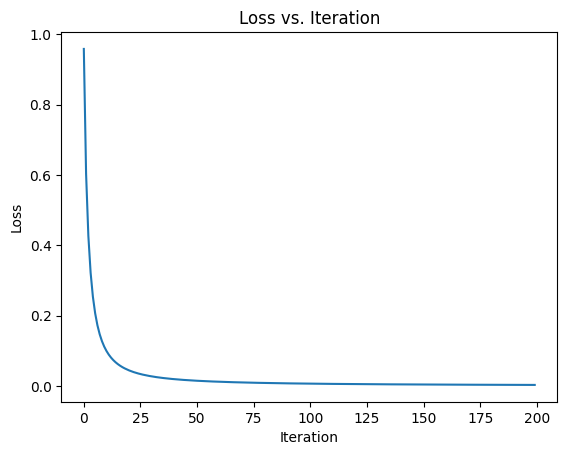

In [15]:
plot_losses(losses)

### Build same model with pyTorch 

In [16]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        # self.fc3 = nn.Linear(4, 4)
        self.fc4 = nn.Linear(4, 1)        

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))        
        x = self.fc4(x)  
        return x



model = MLP_torch()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

losses = []
for epoch in range(40):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")


Epoch 0 loss: 1.3195509910583496
Epoch 10 loss: 0.4273889362812042
Epoch 20 loss: 0.027823850512504578
Epoch 30 loss: 0.0009819257538765669

Prediction:
tensor([[ 0.9917],
        [-0.9984]])
Loss: 4.9306665459880605e-05


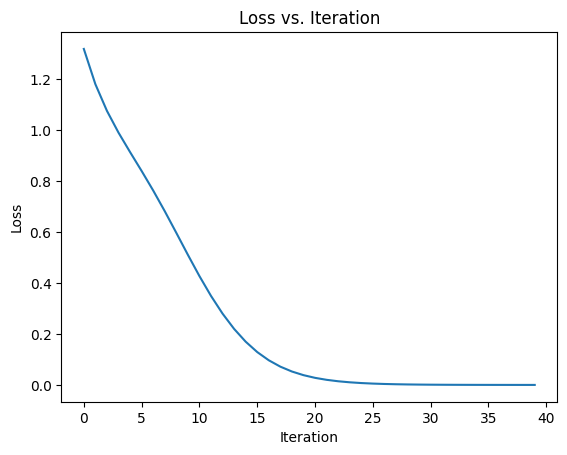

In [17]:
plot_losses(losses)

In [18]:
print(f'input xs:\n{xs}\n')
print(f'target ys:\n{ys}')
print('---------\n')
l_items = list(model.parameters())
if len(l_items) % 2 == 0:
  for i in range(0, len(l_items), 2):
    if i == 0:
      x0 = torch.clone(t_xs).detach() 
      input = torch.transpose(x0, 0, 1)
    else:
      input = output

    w = l_items[i].detach()  # remove gradient
    b_ = l_items[i + 1].detach()  # remove gradient
    b = torch.clone(b_).detach()  # remove gradient
    bT = torch.unsqueeze(b, 1)  # add a dimension to index 1 position
    w_input = torch.matmul(w, input)
    w_input_bT = torch.add(w_input, bT)

    if i == len(l_items) - 2:  # skip tanh activation on output node
      output = w_input_bT
    else:  
      output = torch.tanh(w_input_bT)      

    print(f'layer: {i / 2},  i: {i}\n')
    print(f'w,  {w.shape}:\n{w}\n')
    print(f'input,  {input.shape}:\n{input}\n')
    print(f'w * input,  {w_input.shape}:\n{w_input}\n')        
    print(f'bT,  {bT.shape}:\n{bT}\n')
    print(f'w * input + bT,  {w_input_bT.shape}:\n{w_input_bT}\n')
    print(f'output,  {output.shape}:\n{output}\n')            
    print('')
else:
  raise ValueError(f"len(l_items) {len(l_items)} is not divisible by 2.")

input xs:
[[2.0, 3.0, -1.0], [3.0, -1.0, 0.5]]

target ys:
[1.0, -1.0]
---------

layer: 0.0,  i: 0

w,  torch.Size([4, 3]):
tensor([[ 0.3463, -0.3841,  0.0556],
        [-0.1493,  0.0847, -0.4362],
        [-0.1314,  0.2131, -0.0163],
        [ 0.0778,  0.4130, -0.6206]])

input,  torch.Size([3, 2]):
tensor([[ 2.0000,  3.0000],
        [ 3.0000, -1.0000],
        [-1.0000,  0.5000]])

w * input,  torch.Size([4, 2]):
tensor([[-0.5153,  1.4506],
        [ 0.3917, -0.7508],
        [ 0.3927, -0.6154],
        [ 2.0153, -0.4898]])

bT,  torch.Size([4, 1]):
tensor([[-0.4412],
        [-0.1923],
        [ 0.0503],
        [-0.5673]])

w * input + bT,  torch.Size([4, 2]):
tensor([[-0.9565,  1.0094],
        [ 0.1993, -0.9431],
        [ 0.4430, -0.5651],
        [ 1.4479, -1.0571]])

output,  torch.Size([4, 2]):
tensor([[-0.7427,  0.7655],
        [ 0.1967, -0.7367],
        [ 0.4162, -0.5117],
        [ 0.8953, -0.7846]])


layer: 1.0,  i: 2

w,  torch.Size([4, 4]):
tensor([[-0.2441,  0.216

In [19]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.Size([1, 2])

In [20]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

print(output, output.shape)
print(t_ys_, t_ys_.shape)

difference = output - t_ys_
squared_difference = torch.pow(difference, 2)
# loss = torch.sum(squared_difference) / len(squared_difference)

# loss = torch.sum(squared_difference)
loss = torch.mean(squared_difference)
loss

tensor([[ 0.9917, -0.9984]]) torch.Size([1, 2])
tensor([[ 1., -1.]]) torch.Size([1, 2])


tensor(3.5483e-05)

In [21]:
print(output, output.shape)
print(torch.tensor(ys), torch.tensor(ys).shape)

difference = output - torch.tensor(ys)
print(f'difference: {difference}')
squared_difference = torch.pow(difference, 2)
print(f'squared_difference: {squared_difference}')
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.mean(squared_difference)
loss

tensor([[ 0.9917, -0.9984]]) torch.Size([1, 2])
tensor([ 1., -1.]) torch.Size([2])
difference: tensor([[-0.0083,  0.0016]])
squared_difference: tensor([[6.8448e-05, 2.5179e-06]])


tensor(3.5483e-05)

In [22]:
# for item in output.item:
#   print(item)
# type(output)
output.tolist()[0]


[0.9917266964912415, -0.9984132051467896]

In [23]:
import numpy as np

def mse_loss(y_true, y_pred):
  """Calculates the mean squared error loss.

  Args:
    y_true: The ground truth labels.
    y_pred: The predicted labels.

  Returns:
    The mean squared error loss.
  """

  loss = np.mean((y_true - y_pred)**2)
  return loss

def main():
  """Main function."""

  # y_true = np.array([1, 2, 3, 4, 5])
  y_true = np.array([1.0, -1.0])

  # y_pred = np.array([0, 1, 2, 3, 4])
  # y_pred = np.array([0.9997345209121704, -0.9980572462081909])
  y_pred = np.array(output.tolist()[0])  

  loss = mse_loss(y_true, y_pred)
  print(loss)

if __name__ == "__main__":
  main()

3.548273442710581e-05


In [24]:
len(squared_difference)


1

In [25]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.nn.functional.mse_loss(output, t_ys_)

tensor(3.5483e-05)

In [26]:
torch.sum((output - torch.tensor(ys))**2)


tensor(7.0965e-05)

##### Check Output and Gradient Calculation with PyTorch

In [27]:
x0 = torch.Tensor([-3.0]).double();      x0.requires_grad = True
x1 = torch.Tensor([0.0]).double();       x1.requires_grad = True
x2 = torch.Tensor([0.5]).double();       x2.requires_grad = True
w0 = torch.Tensor([2.0]).double();       w0.requires_grad = True
w1 = torch.Tensor([1.0]).double();       w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();       w2.requires_grad = True
b = torch.Tensor([4.61862664]).double(); b.requires_grad  = True
n = x0*w0 + x1*w1 + x2*w2 + b
o3 = torch.tanh(n)
o3.backward()

print('---- torch results matched backward pass results ----')
print(f'x0.data.item()  = {x0.data.item():>9.6f}')
print(f'x0.grad.item()  = {x0.grad.item():>9.6f}')
print(f'w0.data.item()  = {w0.data.item():>9.6f}')
print(f'w0.grad.item()  = {w0.grad.item():>9.6f} <-- result matched micrograd')
print('---')
print(f'x1.data.item()  = {x1.data.item():>9.6f}')
print(f'x1.grad.item()  = {x1.grad.item():>9.6f}')
print(f'w1.data.item()  = {w1.data.item():>9.6f}')
print(f'w1.grad.item()  = {w1.grad.item():>9.6f}')
print('---')
print(f'x2.data.item()  = {x2.data.item():>9.6f}')
print(f'x2.grad.item()  = {x2.grad.item():>9.6f}')
print(f'w2.data.item()  = {w2.data.item():>9.6f}')
print(f'w2.grad.item()  = {w2.grad.item():>9.6f}')
print('---')
print(f'out.data.item() = {o3.data.item():>9.6f} <-- result matched micrograd')


---- torch results matched backward pass results ----
x0.data.item()  = -3.000000
x0.grad.item()  =  1.000000
w0.data.item()  =  2.000000
w0.grad.item()  = -1.500000 <-- result matched micrograd
---
x1.data.item()  =  0.000000
x1.grad.item()  =  0.500000
w1.data.item()  =  1.000000
w1.grad.item()  =  0.000000
---
x2.data.item()  =  0.500000
x2.grad.item()  =  0.500000
w2.data.item()  =  1.000000
w2.grad.item()  =  0.250000
---
out.data.item() = -0.707107 <-- result matched micrograd


### Neural Network MLP(3, [4, 4, 1])
    input layer:     3 nodes
    hidden layer 1:  4 nodes
    hidden layer 2:  4 nodes
    output layer:    1 node

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\neural_network_neuron.PNG">

### Create neural work, initialize weights and biases, define inputs and desired outputs 

In [28]:
# create neural network and initialize weights and biases
n = MLP(3, [4, 4, 1])

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

In [29]:
# number of parameters (e.g sum (weights + bias to each neuron and output))
# MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
print(f'parameters in MLP: {len(n.parameters())}\n')

# print first 5 parameters
for i, v in enumerate(n.parameters()):
  if i < 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')
 
print('---')

# print last 5 parameters   
for i, v in enumerate(n.parameters()):
  if i >= len(n.parameters()) - 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')

parameters in MLP: 41

i:  0,   0.6238185157
i:  1,  -0.4846932912
i:  2,   0.9071775278
i:  3,  -0.8117812646
i:  4,  -0.7937747591
---
i: 36,  -0.5866888834
i: 37,  -0.7141357036
i: 38,   0.2106535828
i: 39,  -0.6678599824
i: 40,   0.1180751661


### ---- Start: Calculate Neural Network Output and Loss with Matrix Multiplication ----

##### Transpose inputs xs

In [30]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats[0].shape: (2, 3)
xs_mats:
[array([[ 2. ,  3. , -1. ],
       [ 3. , -1. ,  0.5]])]

xs_mats_T[0].shape: (3, 2)
xs_mats_T:
[array([[ 2. ,  3. ],
       [ 3. , -1. ],
       [-1. ,  0.5]])]


##### Get Neural Network's Weights and Biases Matrices

In [31]:
layer_cnt = len(n.layers)
w_mats = []  # list of weights matrix for each layer 
b_mats = []  # list of bias matrix for each layer
print(f'layer_cnt: {layer_cnt}\n')
for i, layer in enumerate(n.layers):
    neuron_cnt = len(layer.neurons)
    print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

    print('----')
    b_mat = []  # accumulate neuon's bias for each row     
    for j, neuron in enumerate(layer.neurons):
        print(f'layer: {i}, neuron {j}')
        b = neuron.b.data  # bias of neuron 
        w_row = []  # accumulate neuon's weights for each row
        # b_row = []  # accumulate neuon's bias for each row
        for k, w in enumerate(neuron.w):
            w_row.append(w.data)
            print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
        if j == 0:            
            w_mat = np.array([w_row])
        else:
            w_mat = np.vstack((w_mat, w_row))
        
        b_mat.append(b)
        print(f'b:  {b:10.7f}\n')
        # print(f'b:  {b:10.7f}')        
        # print(f'b_mat:  {b_mat}\n')
    w_mats.append(w_mat)  
    b_mats.append(np.array([b_mat]))        
    print('------')

layer_cnt: 3

layer: 0, neuron_cnt: 4
----
layer: 0, neuron 0
w0:  0.6238185,   w0.grad:  0.0000000
w1: -0.4846933,   w1.grad:  0.0000000
w2:  0.9071775,   w2.grad:  0.0000000
b:  -0.8117813

layer: 0, neuron 1
w0: -0.7937748,   w0.grad:  0.0000000
w1:  0.5893272,   w1.grad:  0.0000000
w2:  0.4087466,   w2.grad:  0.0000000
b:   0.8013964

layer: 0, neuron 2
w0: -0.5152178,   w0.grad:  0.0000000
w1: -0.9908527,   w1.grad:  0.0000000
w2: -0.4739887,   w2.grad:  0.0000000
b:  -0.1538711

layer: 0, neuron 3
w0:  0.2336745,   w0.grad:  0.0000000
w1: -0.7774972,   w1.grad:  0.0000000
w2: -0.6889257,   w2.grad:  0.0000000
b:   0.9689319

------
layer: 1, neuron_cnt: 4
----
layer: 1, neuron 0
w0:  0.0760687,   w0.grad:  0.0000000
w1:  0.2950475,   w1.grad:  0.0000000
w2:  0.3495016,   w2.grad:  0.0000000
w3:  0.4515870,   w3.grad:  0.0000000
b:  -0.7572596

layer: 1, neuron 1
w0:  0.0132854,   w0.grad:  0.0000000
w1: -0.1261447,   w1.grad:  0.0000000
w2:  0.6458190,   w2.grad:  0.0000000
w3: -

##### Print Neural Network's Weights and Biases Matrices

In [32]:
zipped_w_n_b = zip(w_mats, b_mats)
for i, w_n_b in enumerate(zipped_w_n_b):
  print(f'i: {i}')    
  print(f'w_mat{w_n_b[0].shape}:\n{w_n_b[0]}')
  print(f'b_mat{w_n_b[1].shape}:\n{w_n_b[1]}\n')  
    

i: 0
w_mat(4, 3):
[[ 0.62381852 -0.48469329  0.90717753]
 [-0.79377476  0.58932717  0.40874663]
 [-0.51521781 -0.99085274 -0.47398872]
 [ 0.2336745  -0.7774972  -0.68892565]]
b_mat(1, 4):
[[-0.81178126  0.8013964  -0.1538711   0.9689319 ]]

i: 1
w_mat(4, 4):
[[ 0.07606871  0.29504752  0.34950159  0.45158704]
 [ 0.01328539 -0.12614475  0.64581901 -0.7132814 ]
 [-0.20630252  0.9401353   0.22428775 -0.13232552]
 [ 0.59818706 -0.50898908 -0.34069425  0.84655468]]
b_mat(1, 4):
[[-0.75725956 -0.56568375 -0.64429868  0.51509571]]

i: 2
w_mat(1, 4):
[[-0.58668888 -0.7141357   0.21065358 -0.66785998]]
b_mat(1, 1):
[[0.11807517]]



##### Calculate Neural Network Output and Loss with Matrix Multiplication

<img src="..\karpathy\img\neural_mat.PNG">

In [33]:
verbose = True   # print calculation output and weights and bias matrices 
# verbose = False  # print calculation output only

for layer in range(len(n.layers)):
  if layer == 0:  # first layer, use given inputs xs as inputs
    input = xs_mats_T[layer]
  else:  # after first layer, use outputs from preceding layers as inputs
    input = output

  weights = w_mats[layer]
  bias = np.transpose(b_mats[layer])

  weights_x_input = np.matmul(weights, input)
  weights_x_input_plus_bias = weights_x_input + bias

  # output = np.tanh(np.matmul(weights, input) + bias)
  output = np.tanh(weights_x_input_plus_bias)

  if verbose:
    print(f'{"-"*50}')
    print(f'layer: {layer}')
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')

    print(f'weights_x_inputs {weights_x_input.shape}:\n{weights_x_input}\n')
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'weights_x_inputs_plus_bias {weights_x_input_plus_bias.shape}:\n{weights_x_input_plus_bias}\n')

    print(f'output {output.shape}:\n{output}\n')    

yout = output[0]
loss = sum((yout - ys)**2)

print(f'-- manual forward pass calculation --')
print(f'manual calculation: {yout}')   
print(f'desired output:     {ys}')   
print(f'loss:               {loss}')


--------------------------------------------------
layer: 0
weights (4, 3):
[[ 0.62381852 -0.48469329  0.90717753]
 [-0.79377476  0.58932717  0.40874663]
 [-0.51521781 -0.99085274 -0.47398872]
 [ 0.2336745  -0.7774972  -0.68892565]]

input (3, 2):
[[ 2.   3. ]
 [ 3.  -1. ]
 [-1.   0.5]]

weights_x_inputs (4, 2):
[[-1.11362037  2.8097376 ]
 [-0.22831464 -2.76627813]
 [-3.52900513 -0.79179505]
 [-1.17621695  1.13405789]]

bias (4, 1):
[[-0.81178126]
 [ 0.8013964 ]
 [-0.1538711 ]
 [ 0.9689319 ]]

weights_x_inputs_plus_bias (4, 2):
[[-1.92540163  1.99795634]
 [ 0.57308176 -1.96488173]
 [-3.68287624 -0.94566615]
 [-0.20728505  2.10298979]]

output (4, 2):
[[-0.95836008  0.96388291]
 [ 0.51761894 -0.9614606 ]
 [-0.9987357  -0.73781473]
 [-0.20436639  0.97062551]]

--------------------------------------------------
layer: 1
weights (4, 4):
[[ 0.07606871  0.29504752  0.34950159  0.45158704]
 [ 0.01328539 -0.12614475  0.64581901 -0.7132814 ]
 [-0.20630252  0.9401353   0.22428775 -0.13232552]
 [

### ### ---- End: Calculate Neural Network Output and Loss with Matrix Multiplication ---- ----

### Prediction with Micrograd Neural Network

##### Micrograd Forward Pass Results, Same as Matrix Multiplication

In [34]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
loss_data = loss.data

print(f'-- micrograd forward pass calculation --')
print(f'ypred_data:         {ypred_data}')
print(f'ys:                 {ys}')
print(f'loss_data:          {loss_data}')

-- micrograd forward pass calculation --
ypred_data:         [0.8464337963960112, 0.2882992740504464]
ys:                 [1.0, -1.0]
loss_data:          1.683297598408249


#### Micrograd backward pass and update parameters

In [35]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
if verbose:
  print('=== update parameters ===')
  print(f'  i  parameter before         gradient     learning rate      parameter after')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad
  if verbose:    
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')

=== update parameters ===
  i  parameter before         gradient     learning rate      parameter after
  0      0.6238185157    -0.0124288075           0.05000         0.6244399560
  1     -0.4846932912     0.0158936995           0.05000        -0.4854879762
  2      0.9071775278    -0.0063444729           0.05000         0.9074947514
  3     -0.8117812646    -0.0030746846           0.05000        -0.8116275304
  4     -0.7937747591    -0.0981017864           0.05000        -0.7888696697
  5      0.5893271688    -0.0830280560           0.05000         0.5934785716
  6      0.4087466311     0.0257328483           0.05000         0.4074599887
  7      0.8013963993    -0.0432213820           0.05000         0.8035574684
  8     -0.5152178102    -0.5761658345           0.05000        -0.4864095185
  9     -0.9908527433     0.1920211614           0.05000        -1.0004538014
 10     -0.4739887170    -0.0960152330           0.05000        -0.4691879554
 11     -0.1538711023    -0.1920583797

### Improve Prediction with Parameter Iteration 

In [36]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = 0.770792030386018), Value(data = -0.25365871269513124)]
step: 0, loss: 0.6095616104704527
-------
ypred: [Value(data = 0.7652311658640878), Value(data = -0.5159740468753516)]
step: 1, loss: 0.28939752877975977
-------
ypred: [Value(data = 0.7943944415338288), Value(data = -0.6173521186326665)]
step: 2, loss: 0.18869304678709511
-------
ypred: [Value(data = 0.8159373227067621), Value(data = -0.6753645491421034)]
step: 3, loss: 0.13926724512606442
-------
ypred: [Value(data = 0.8316025210690254), Value(data = -0.7140265208609187)]
step: 4, loss: 0.1101385416812186
-------
ypred: [Value(data = 0.8435885893198782), Value(data = -0.7420715940119759)]
step: 5, loss: 0.09099159200646871
-------
ypred: [Value(data = 0.8531528511880074), Value(data = -0.7635700387981491)]
step: 6, loss: 0.0774632116681202
-------
ypred: [Value(data = 0.8610302001439198), Value(data = -0.7807047494008471)]
step: 7, loss: 0.06740301220738425
-------
ypred: [Value(data = 0.8676768265204678), V

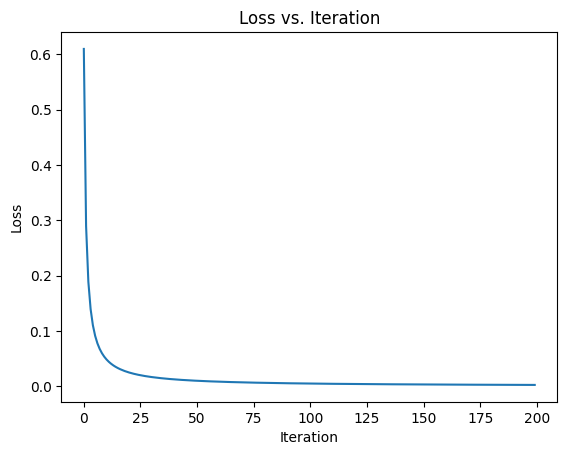

In [37]:
plot_losses(losses)

### Build same model with pyTorch 

In [38]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        # self.fc3 = nn.Linear(4, 4)
        self.fc4 = nn.Linear(4, 1)        

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))        
        x = self.fc4(x)  
        return x



model = MLP_torch()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

losses = []
for epoch in range(40):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")


Epoch 0 loss: 1.1391258239746094
Epoch 10 loss: 0.4605425000190735
Epoch 20 loss: 0.05065038800239563
Epoch 30 loss: 0.0016020669136196375

Prediction:
tensor([[ 0.9940],
        [-0.9940]])
Loss: 5.3315689001465216e-05


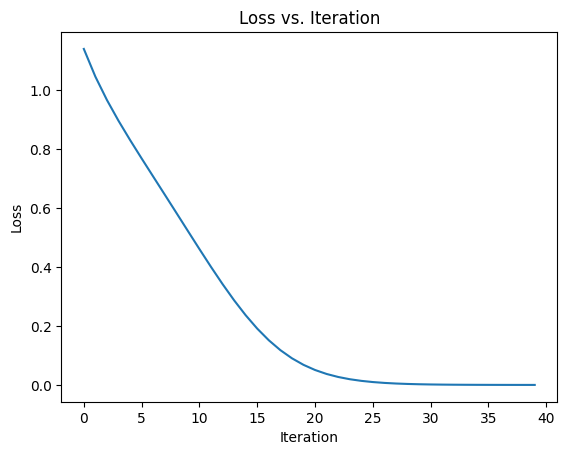

In [39]:
plot_losses(losses)

In [40]:
print(f'input xs:\n{xs}\n')
print(f'target ys:\n{ys}')
print('---------\n')
l_items = list(model.parameters())
if len(l_items) % 2 == 0:
  for i in range(0, len(l_items), 2):
    if i == 0:
      x0 = torch.clone(t_xs).detach() 
      input = torch.transpose(x0, 0, 1)
    else:
      input = output

    w = l_items[i].detach()  # remove gradient
    b_ = l_items[i + 1].detach()  # remove gradient
    b = torch.clone(b_).detach()  # remove gradient
    bT = torch.unsqueeze(b, 1)  # add a dimension to index 1 position
    w_input = torch.matmul(w, input)
    w_input_bT = torch.add(w_input, bT)

    if i == len(l_items) - 2:  # skip tanh activation on output node
      output = w_input_bT
    else:  
      output = torch.tanh(w_input_bT)      

    print(f'layer: {i / 2},  i: {i}\n')
    print(f'w,  {w.shape}:\n{w}\n')
    print(f'input,  {input.shape}:\n{input}\n')
    print(f'w * input,  {w_input.shape}:\n{w_input}\n')        
    print(f'bT,  {bT.shape}:\n{bT}\n')
    print(f'w * input + bT,  {w_input_bT.shape}:\n{w_input_bT}\n')
    print(f'output,  {output.shape}:\n{output}\n')            
    print('')
else:
  raise ValueError(f"len(l_items) {len(l_items)} is not divisible by 2.")

input xs:
[[2.0, 3.0, -1.0], [3.0, -1.0, 0.5]]

target ys:
[1.0, -1.0]
---------

layer: 0.0,  i: 0

w,  torch.Size([4, 3]):
tensor([[-0.5252,  0.1233,  0.0581],
        [ 0.2622,  0.5055,  0.1071],
        [-0.3412, -0.4693,  0.3877],
        [ 0.4759, -0.6939,  0.3442]])

input,  torch.Size([3, 2]):
tensor([[ 2.0000,  3.0000],
        [ 3.0000, -1.0000],
        [-1.0000,  0.5000]])

w * input,  torch.Size([4, 2]):
tensor([[-0.7386, -1.6699],
        [ 1.9339,  0.3347],
        [-2.4781, -0.3605],
        [-1.4741,  2.2936]])

bT,  torch.Size([4, 1]):
tensor([[ 0.1440],
        [-0.5113],
        [ 0.0463],
        [ 0.0045]])

w * input + bT,  torch.Size([4, 2]):
tensor([[-0.5946, -1.5259],
        [ 1.4226, -0.1766],
        [-2.4318, -0.3142],
        [-1.4696,  2.2981]])

output,  torch.Size([4, 2]):
tensor([[-0.5332, -0.9097],
        [ 0.8901, -0.1748],
        [-0.9847, -0.3042],
        [-0.8995,  0.9800]])


layer: 1.0,  i: 2

w,  torch.Size([4, 4]):
tensor([[ 0.0639,  0.208

In [41]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.Size([1, 2])

In [42]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

print(output, output.shape)
print(t_ys_, t_ys_.shape)

difference = output - t_ys_
squared_difference = torch.pow(difference, 2)
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference)
loss

tensor([[ 0.9940, -0.9940]]) torch.Size([1, 2])
tensor([[ 1., -1.]]) torch.Size([1, 2])


tensor(7.2735e-05)

In [43]:
print(output, output.shape)
print(torch.tensor(ys), torch.tensor(ys).shape)

difference = output - torch.tensor(ys)
print(f'difference: {difference}')
squared_difference = torch.pow(difference, 2)
print(f'squared_difference: {squared_difference}')
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference) / 2
loss

tensor([[ 0.9940, -0.9940]]) torch.Size([1, 2])
tensor([ 1., -1.]) torch.Size([2])
difference: tensor([[-0.0060,  0.0060]])
squared_difference: tensor([[3.6405e-05, 3.6330e-05]])


tensor(3.6368e-05)

In [44]:
difference
len(squared_difference)

1

In [45]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.nn.functional.mse_loss(output, t_ys_)

tensor(3.6368e-05)

In [46]:
torch.sum((output - torch.tensor(ys))**2)

tensor(7.2735e-05)